<a href="https://colab.research.google.com/github/pooriaazami/deep_learning_class_notebooks/blob/main/17_Pix2Pix_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install -q kaggle

In [9]:
from google.colab import files

In [ ]:
files.upload()

In [4]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d vikramtiwari/pix2pix-dataset

In [ ]:
!unzip pix2pix-dataset.zip
!rm pix2pix-dataset.zip

In [ ]:
!mkdir dataset

!mv cityscapes/cityscapes/ dataset/
!mv edges2shoes/edges2shoes/ dataset/
!mv facades/facades/ dataset/
!mv maps/maps/ dataset/

!rmdir cityscapes edges2shoes facades maps

In [12]:
import os
import glob
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [13]:
DATASET_ROOT = 'dataset'
DATASET = 'facades'

IMAGE_EDGE = 256

ALPHA = 100

BATCH_SIZE = 8
EPOCHS = 10

LR = 2e-4
BETA_1 = .5
BETA_2 = .99

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
class Pix2PixDataset:
  def __init__(self, root, dataset, split, transforms=None):
    self.transforms = transforms

    self.root = os.path.join(root, dataset, split)
    assert os.path.isdir(self.root), f'No such directory: {self.root}'

    self.images = glob.glob(self.root + '/*.jpg')

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = Image.open(self.images[idx]).convert('RGB')
    image = np.array(image)

    _, w, _ = image.shape
    input_image = image[:, w//2:, :]
    label = image[:, :w//2, :]

    if self.transforms:
      input_image = self.transforms(input_image)
      label = self.transforms(label)

    return input_image, label

In [15]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    nn.init.normal_(m.weight, .0, .02)
  if isinstance(m, nn.BatchNorm2d):
    nn.init.normal_(m.weight, .2, .02)
    nn.init.constant_(m.bias, 0)

In [16]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.conv_blocks = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels),
    )

  def forward(self, x):
    return self.conv_blocks(x)

In [17]:
class DownBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.conv_blocks = nn.Sequential(
        nn.MaxPool2d(2),
        ConvBlock(in_channels, out_channels).apply(initialize_weights)
    )

  def forward(self, x):
    return self.conv_blocks(x)

In [18]:
class UpBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.up = nn.ConvTranspose2d(in_channels=in_channels, out_channels=in_channels//2, kernel_size=2, stride=2).apply(initialize_weights)
    self.conv_blocks = ConvBlock(in_channels, out_channels).apply(initialize_weights)

  def forward(self, x, residual_inputs):
    x = self.up(x)

    diff_y = residual_inputs.size()[2] - x.size()[2]
    diff_x = residual_inputs.size()[3] - x.size()[3]

    x = F.pad(x, [diff_x // 2, diff_x - diff_x // 2,
                  diff_y // 2, diff_y - diff_y // 2])

    x = torch.cat([residual_inputs, x], dim=1)
    x = self.conv_blocks(x)

    return x

In [19]:
class OutBlock(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=num_classes, kernel_size=1).apply(initialize_weights)

  def forward(self, x):
    return self.conv(x)

In [20]:
class UNet(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.input_block = ConvBlock(in_channels, 64).apply(initialize_weights)

    self.down_1 = DownBlock(64, 128)
    self.down_2 = DownBlock(128, 256)
    self.down_3 = DownBlock(256, 512)
    self.down_4 = DownBlock(512, 1024)

    self.up_4 = UpBlock(1024, 512)
    self.up_3 = UpBlock(512, 256)
    self.up_2 = UpBlock(256, 128)
    self.up_1 = UpBlock(128, 64)

    self.output_block = OutBlock(64, num_classes)

  def forward(self, x):
    down_cache_1 = self.input_block(x)

    down_cache_2 = self.down_1(down_cache_1)
    down_cache_3 = self.down_2(down_cache_2)
    down_cache_4 = self.down_3(down_cache_3)
    down_cache_5 = self.down_4(down_cache_4)

    x = self.up_4(down_cache_5, down_cache_4)
    x = self.up_3(x, down_cache_3)
    x = self.up_2(x, down_cache_2)
    x = self.up_1(x, down_cache_1)

    x = self.output_block(x)

    return x

In [21]:
class Discriminator(nn.Module):
  def __init__(self, image_edge):
    super().__init__()

    self.layers = nn.Sequential(
        ConvBlock(3, 64),
        DownBlock(64, 128),
        DownBlock(128, 256),
        DownBlock(256, 512),
        DownBlock(512, 512),

        nn.Flatten(1),

        nn.Linear(512 * (image_edge // (2 ** 4)) ** 2, 256),
        nn.ReLU(),
        nn.Linear(256, 1)
    )

  def forward(self, x):
    return self.layers(x)

In [22]:
class GeneratorLoss(nn.Module):
  def __init__(self, alpha):
    super().__init__()

    self.bce = nn.BCEWithLogitsLoss()
    self.l1 = nn.L1Loss()
    self.alpha = alpha

  def forward(self, predictions, generated_images, labels):
    adversarial_loss = self.bce(predictions, torch.ones_like(predictions))
    generation_loss = self.l1(generated_images, labels)

    total_loss = adversarial_loss + self.alpha * generation_loss
    return total_loss

In [23]:
class DiscriminatorLoss(nn.Module):
  def __init__(self):
    super().__init__()

    self.bce = nn.BCEWithLogitsLoss()

  def forward(self, fake_predictions, real_predictions):
    total_loss = .5 * (self.bce(fake_predictions, torch.zeros_like(fake_predictions)) + \
                       self.bce(real_predictions, torch.ones_like(real_predictions)))

    return total_loss

In [24]:
def train_discriminator(x, y, generator, discriminator, loss_function, optimizer):
  optimizer.zero_grad()

  fake_images = generator(x)
  fake_images_predictions = discriminator(fake_images)

  real_images_predictions = discriminator(y)

  loss = loss_function(fake_images_predictions, real_images_predictions)
  loss.backward()

  optimizer.step()

  return loss.detach().cpu().item()

In [25]:
def train_generator(x, y, generator, discriminator, loss_function, optimizer):
  optimizer.zero_grad()

  fake_images = generator(x)
  fake_images_predictions = discriminator(fake_images)

  loss = loss_function(fake_images_predictions, fake_images, y)
  loss.backward()

  optimizer.step()

  return loss.detach().cpu().item()

In [26]:
generator = UNet(3, 3).to(DEVICE)
discriminator = Discriminator(IMAGE_EDGE).to(DEVICE)

In [27]:
generator_loss = GeneratorLoss(ALPHA)
discriminator_loss = DiscriminatorLoss()

In [28]:
generator_optimizer = optim.Adam(generator.parameters(), lr=LR, betas=(BETA_1, BETA_2))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA_1, BETA_2))

In [29]:
transforms = T.ToTensor()

train_dataset = Pix2PixDataset(DATASET_ROOT, DATASET, 'train', transforms=transforms)
val_dataset = Pix2PixDataset(DATASET_ROOT, DATASET, 'val', transforms=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [30]:
train_generator_fixed = partial(train_generator,
                                generator=generator,
                                discriminator=discriminator,
                                loss_function=generator_loss,
                                optimizer=generator_optimizer)

train_discriminator_fixed = partial(train_discriminator,
                                    generator=generator,
                                    discriminator=discriminator,
                                    loss_function=discriminator_loss,
                                    optimizer=discriminator_optimizer)

In [31]:
discrimiantor_log = []
generator_log = []

In [32]:
for epoch in range(1, EPOCHS + 1):
  print(f'Epoch {epoch} / {EPOCHS}')

  total_generator_loss = .0
  total_discriminator_loss = .0

  for x, y in tqdm(train_dataloader):
    x = x.to(DEVICE)
    y = y.to(DEVICE)

    total_discriminator_loss += train_discriminator_fixed(x, y)
    total_generator_loss += train_generator_fixed(x, y)

  print(f'Discriminator loss: {total_discriminator_loss:.2f}, Generator loss: {total_generator_loss:.2f}')
  discrimiantor_log.append(total_discriminator_loss)
  generator_log.append(total_generator_loss)

Epoch 1 / 10


  0%|          | 0/50 [00:00<?, ?it/s]

Discriminator loss: 6.49, Generator loss: 2805.00
Epoch 2 / 10


  0%|          | 0/50 [00:00<?, ?it/s]

Discriminator loss: 2.48, Generator loss: 3058.16
Epoch 3 / 10


  0%|          | 0/50 [00:00<?, ?it/s]

Discriminator loss: 0.08, Generator loss: 2851.50
Epoch 4 / 10


  0%|          | 0/50 [00:00<?, ?it/s]

Discriminator loss: 6.77, Generator loss: 3331.94
Epoch 5 / 10


  0%|          | 0/50 [00:00<?, ?it/s]

Discriminator loss: 0.43, Generator loss: 3133.23
Epoch 6 / 10


  0%|          | 0/50 [00:00<?, ?it/s]

Discriminator loss: 5.17, Generator loss: 2749.22
Epoch 7 / 10


  0%|          | 0/50 [00:00<?, ?it/s]

Discriminator loss: 21.96, Generator loss: 2238.14
Epoch 8 / 10


  0%|          | 0/50 [00:00<?, ?it/s]

Discriminator loss: 1.47, Generator loss: 2270.52
Epoch 9 / 10


  0%|          | 0/50 [00:00<?, ?it/s]

Discriminator loss: 0.58, Generator loss: 2108.58
Epoch 10 / 10


  0%|          | 0/50 [00:00<?, ?it/s]

Discriminator loss: 1.48, Generator loss: 1916.07


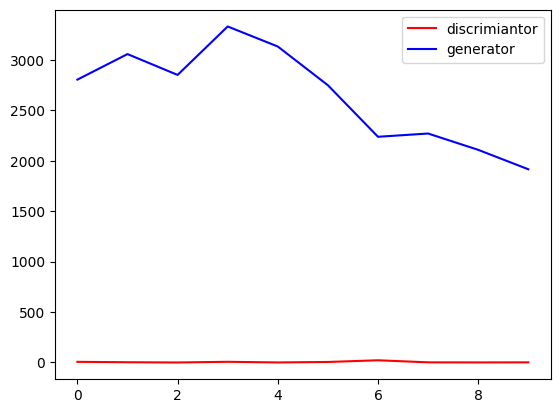

In [47]:
plt.plot(discrimiantor_log, label='discrimiantor', color='red')
plt.plot(generator_log, label='generator', color='blue')

plt.legend()
plt.show()

In [41]:
with torch.no_grad():
  for x, y in val_dataloader:
    x = x.to(DEVICE)
    preds = generator(x).detach().cpu().numpy()
    break

In [42]:
x = x.cpu().numpy()
y = y.numpy()

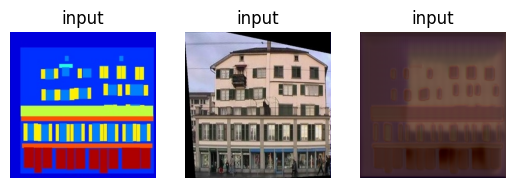

In [45]:
idx = 0

fig, axs = plt.subplots(1, 3)

axs[0].imshow(x[idx].transpose((1, 2, 0)))
axs[0].set_title('input')
axs[0].axis('off')

axs[1].imshow(y[idx].transpose((1, 2, 0)))
axs[1].set_title('input')
axs[1].axis('off')

axs[2].imshow(preds[idx].transpose((1, 2, 0)))
axs[2].set_title('input')
axs[2].axis('off')

plt.show()